### Apoorv Agnihotri 16110020
[Assignment 6](https://nipunbatra.github.io/teaching/ml-spring-19/hw/6.pdf)

In [710]:
# adding relavent directory in includes
import sys
dirr = "../../src"
if dirr not in sys.path:
    sys.path.append(dirr)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from utils import train_timer
import matplotlib.pyplot as plt

# Q1(a)

In [711]:
# Inspired from https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
import operator
import random
import math

class Gaussian:
    def __init__(self):
        pass

    def calculateLogProbability(self, x, mean, stdev):
        '''x, mean and stdev are vectors of resp. fea, returns a scalar'''
#         print ('Helloo', x, mean)
        num  = -np.square(x-mean)
        power = num/(2*np.square(stdev))
        exponent = np.exp(power)
        return np.sum(np.log((1 / (np.sqrt(2*np.pi) * stdev)) * exponent))

class NaiveBayes:
    def __init__(self, method='gaus'):
        if method == 'gaus':
            self.prp = Gaussian()
        
    def train(self, X, y):
        self.dataset = np.concatenate([X, y[:, None]], axis=1)
        self.summeries = self.summarizeByClass(self.dataset)
    
    def separateByClass(self, dataset):
        separated = {}
        for i in range(dataset.shape[0]):
            vector = dataset[i, :]
            if (vector[-1] not in separated):
                separated[vector[-1]] = []
            separated[vector[-1]].append(vector)
        return separated

    def summarize(self, dataset):
        attr_mean = []
        attr_std = []
        for i in range(dataset.shape[1]-1):
            attr = dataset[:, i]
            attr_mean.append(np.mean(attr))
            attr_std.append(np.std(attr))
        return (np.array(attr_mean), np.array(attr_std))
    
    def summarizeByClass(self, dataset):
        separated = self.separateByClass(dataset)
        attrs_mean_std_per_class = {}
        for classValue, instances in separated.items():
            attrs_mean_std_per_class[classValue] = self.summarize(np.array(instances))
        return attrs_mean_std_per_class # is a dict with tuple of vectors

    def calculateClassProbabilities(self, x):
        '''Calculates the class probabilities for x given theta.'''
        summaries = self.summeries
        probabilities = {}
        for classValue, classSummaries in summaries.items():
            # expanding classSummaries -> (mean_vct, std_vct)
            probabilities[classValue] = self.prp.calculateLogProbability(x, *classSummaries)
        return probabilities

    def predict(self, xs, conf=False):
        preds = []
        probs = []
        for x in xs:
            probabilities = self.calculateClassProbabilities(x)
            bestLabel = max(probabilities.items(), key=operator.itemgetter(1))[0]
            preds.append(bestLabel)
            probs.append(probabilities)
        if conf:
            return np.array(preds), np.array(probs)
        else:
            return np.array(preds)

In [712]:
data = pd.read_csv("../../data/iris/iris.csv",
                   header=None,
                   names=['sepal length',
                          'sepal width',
                          'petal length',
                          'petal width',
                          'species'])
X = data.iloc[:, :2]
y = data.iloc[:, -1]
tupl = train_test_split(X, y, test_size = .3, shuffle=True)
X_train, X_test, y_train, y_test = tupl
X_train.head(5)

,sepal length,sepal width
26,5.0,3.4
33,5.5,4.2
99,5.7,2.8
119,6.0,2.2
87,6.3,2.3


In [713]:
nb = NaiveBayes()
nb.train(X_train.values, y_train.values)
y_pred = nb.predict(X_test.values)
acc = np.sum(y_pred == y_test)/len(y_test)
print ("accuracy: ", acc)

accuracy:  0.7333333333333333


# Q1(b)(i)
Active Learning

In [714]:
from sklearn.utils import shuffle
import time
X, y = shuffle(X, y)
X, y = shuffle(X, y)
tupl = train_test_split(X, y, test_size = .3, shuffle=True)
X_train, X_test, y_train, y_test = tupl
y.head(5)

73     Iris-versicolor
99     Iris-versicolor
82     Iris-versicolor
33         Iris-setosa
124     Iris-virginica
Name: species, dtype: object

In [715]:
tupl = train_test_split(X_train, y_train, test_size=0.9)
X_annotated, X_unannotated, y_annotated, y_unannotated = tupl

In [716]:
X_annotated = X_annotated.values
X_unannotated = X_unannotated.values
y_annotated = y_annotated.values
y_unannotated = y_unannotated.values

In [717]:
nb = NaiveBayes()
annotation_size = 1 # annotation batch size
active_learning_its = 10

accs = []
for _ in range(active_learning_its):
    # training
    nb.train(X_annotated, y_annotated)
    y_pred, y_confi = nb.predict(X_unannotated, conf=True)

#     print ('hmm')
    # storing the accuraices
    y_pred = nb.predict(X_test.values)
    acc = np.sum(y_pred == y_test)/len(y_test)
    accs.append(acc)

    for _ in range(annotation_size):
        # select the least confident point
        least_conf = 1
        lix = -2
        for ix, prob in enumerate(y_confi):
            bestLabel = max(prob.items(), key=operator.itemgetter(1))[0]
            prob_val = prob[bestLabel]
            if prob_val <= least_conf:
                least_conf = prob_val
                lix = ix

        # annotating the least conf.
        X_annotated = np.concatenate([X_annotated, X_unannotated[lix, :][None, :]], axis=0)
        y_annotated = np.concatenate([y_annotated, y_unannotated[lix:lix+1]], axis=0)
        X_unannotated = np.delete(X_unannotated, (lix), axis=0)
        y_unannotated = np.delete(y_unannotated, (lix), axis=0)


D:\Users\apoor\Miniconda3\envs\3d\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
D:\Users\apoor\Miniconda3\envs\3d\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
D:\Users\apoor\Miniconda3\envs\3d\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
D:\Users\apoor\Miniconda3\envs\3d\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


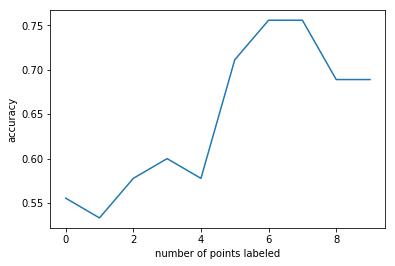

In [732]:
plt.plot(accs)
plt.xlabel("number of points labeled")
plt.ylabel("accuracy");

# Q1(b) (ii)

In [733]:
data = pd.read_csv("../../data/iris/iris.csv",
                   header=None,
                   names=['sepal length',
                          'sepal width',
                          'petal length',
                          'petal width',
                          'species'])
X = data.iloc[:, :2]
y = data.iloc[:, -1]
df = pd.DataFrame(X)
df.columns = ['x','y']

In [734]:
ylabels = (y == 'Iris-virginica') * 1
ylabels += (y == 'Iris-setosa') * 2
ylabels += (y == 'Iris-versicolor') * 3

In [735]:
df['class'] = ylabels

In [736]:
df.head(4)

,x,y,class
0,5.1,3.5,2
1,4.9,3.0,2
2,4.7,3.2,2
3,4.6,3.1,2


In [737]:
from sklearn.utils import shuffle
df = shuffle(df)
tupl = train_test_split(df, test_size = .3, shuffle=True)
df_train, df_test = tupl

In [738]:
# taking out unannotated
tupl = train_test_split(df_train, test_size=0.9)
df_annotated, df_unannotated = tupl

In [739]:
X_annotated = df_annotated[['x', 'y']].values
X_unannotated = df_unannotated[['x', 'y']].values
y_annotated = df_annotated['class'].values
y_unannotated = df_unannotated['class'].values

In [749]:
nb = NaiveBayes()
annotation_size = 1 # annotation batch size
active_learning_its = 1

def somthing(active_learning_its=1, random_sampling=False, plot=True):
    accs = []
    global annotation_size
    global X_annotated
    global y_annotated
    global nb
    global X_unannotated
    global df
    global y_unannotated
    global df_test
    
    if active_learning_its != 1:
        plot=False # gets dirty
    
    for i in range(active_learning_its):
        # training
        nb.train(X_annotated, y_annotated)
        y_pred, y_confi = nb.predict(X_unannotated, conf=True)

        # plotting
        if plot:
            x_min, x_max = df['x'].values.min() - .5, df['x'].max() + .5
            y_min, y_max = df['y'].min() - .5, df['y'].max() + .5
            h = 0.1  # step size in the mesh
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            Z = nb.predict(np.c_[xx.ravel(), yy.ravel()])
            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            source = pd.DataFrame({'x': xx.ravel(),
                             'y': yy.ravel(),
                             'z': Z.ravel()})
            plt.figure(figsize=(20,10)) 
            plt.scatter(df['x'], df['y'], c= df['class'], alpha=0.4, cmap=plt.cm.Paired, edgecolors='grey', s=50 )
            plt.scatter(X_annotated[:,0], X_annotated[:,1], c= y_annotated, 
                        edgecolors='k', s=300, cmap=plt.cm.Paired )
            plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

        # storing the accuraices
        y_pred = nb.predict(df_test[['x','y']].values)
        acc = np.sum(y_pred == df_test['class'].values)/df_test.shape[0]
        accs.append(acc)

        # select the least confident point
        if not random_sampling:
            least_conf = 1
            lix = -2
            for ix, prob in enumerate(y_confi):
                bestLabel = max(prob.items(), key=operator.itemgetter(1))[0]
                prob_val = prob[bestLabel]
                if prob_val <= least_conf:
                    least_conf = prob_val
                    lix = ix

        # randomly select
        else:
            lix=np.random.choice(np.arange(len(y_unannotated)))

        # annotating the least conf.
        X_annotated = np.concatenate([X_annotated, X_unannotated[lix, :][None, :]], axis=0)
        y_annotated = np.concatenate([y_annotated, y_unannotated[lix:lix+1]], axis=0)
        X_unannotated = np.delete(X_unannotated, (lix), axis=0)
        y_unannotated = np.delete(y_unannotated, (lix), axis=0)

        if plot:
            plt.scatter(X_annotated[-1, 0], X_annotated[-1, 1], facecolor='blue', marker='^', s=100)

    return accs

[0.6888888888888889]

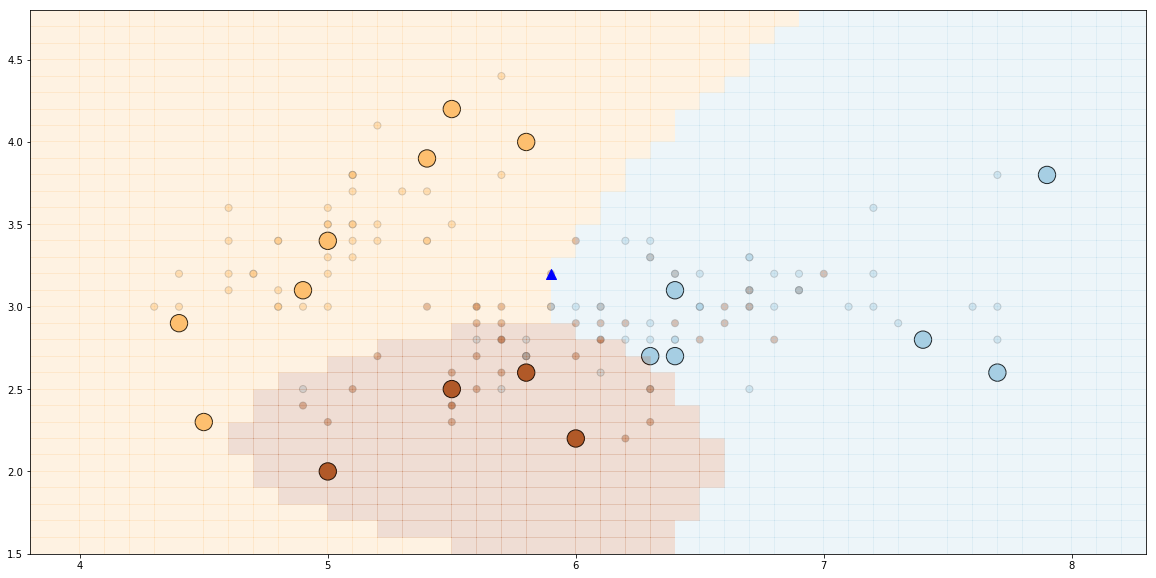

In [750]:
somthing()

[0.7333333333333333]

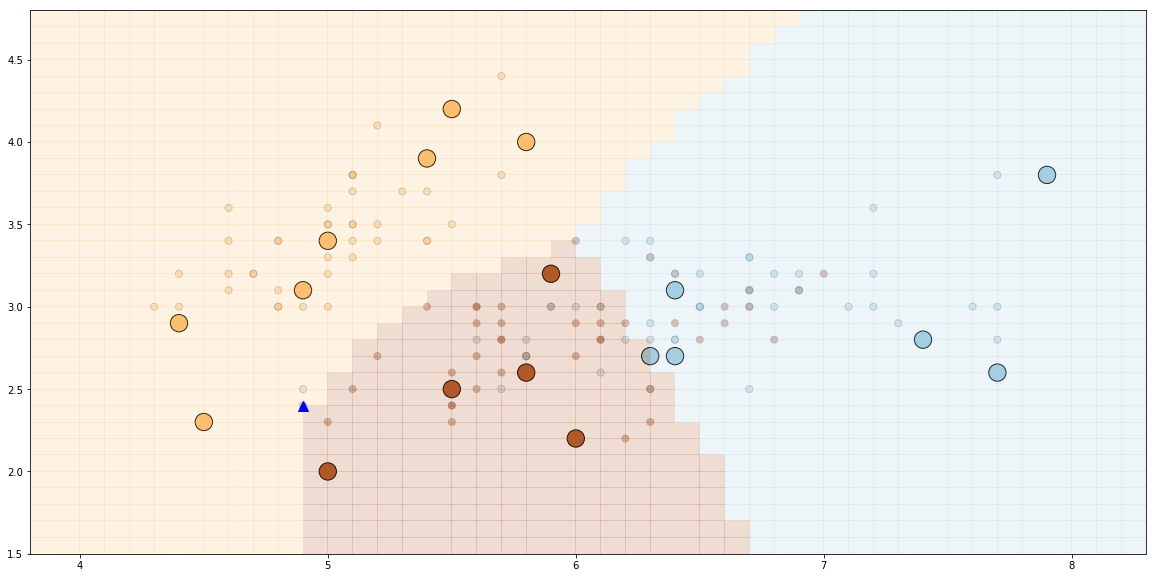

In [751]:
somthing()

[0.7333333333333333]

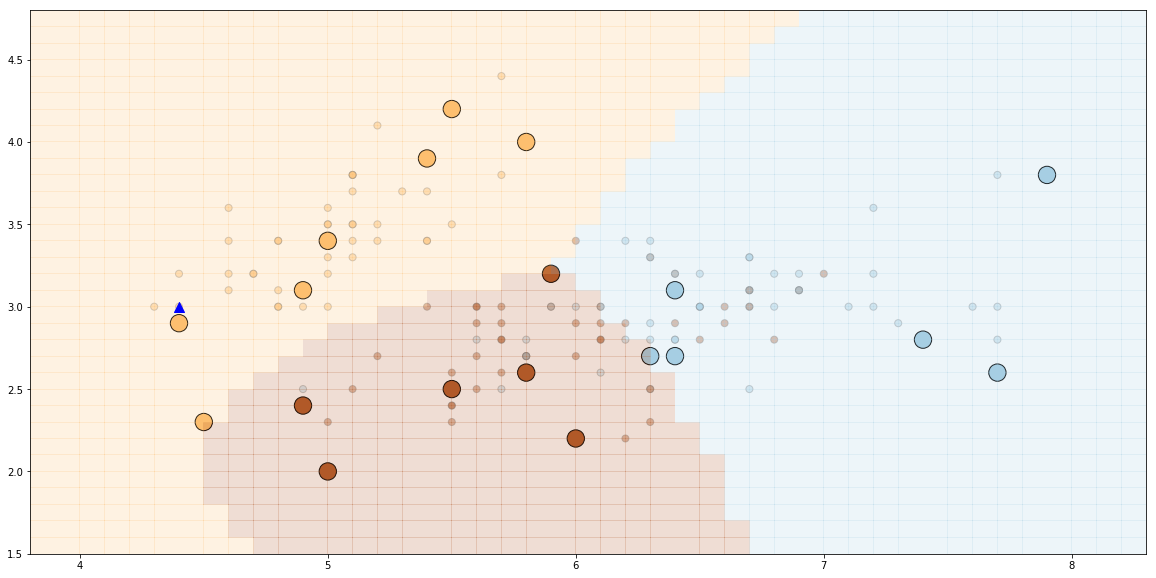

In [752]:
somthing()

[0.7333333333333333]

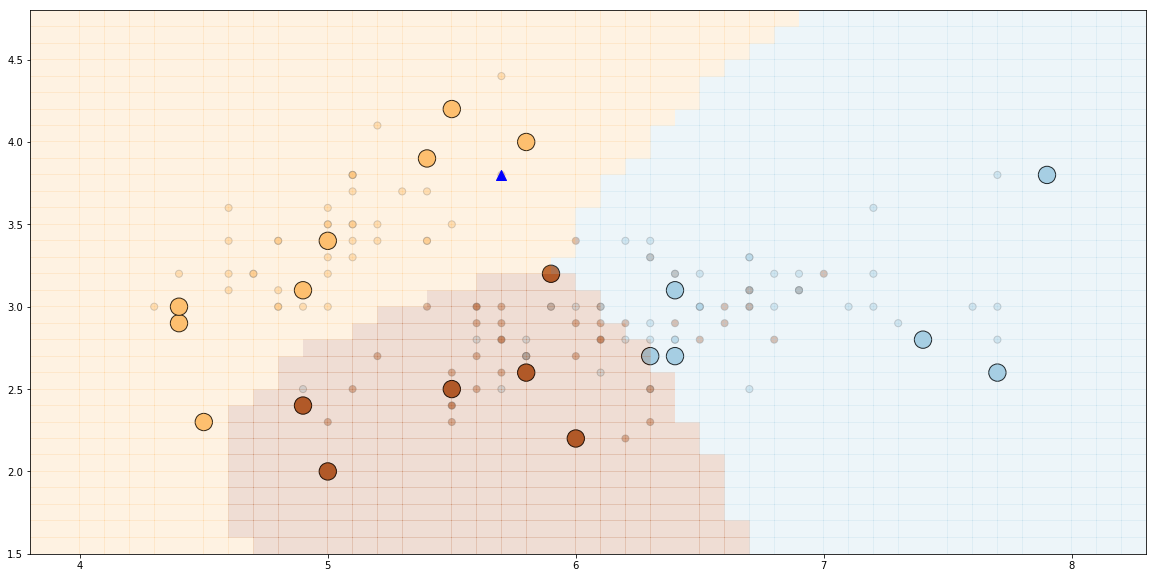

In [753]:
somthing()

[0.7333333333333333]

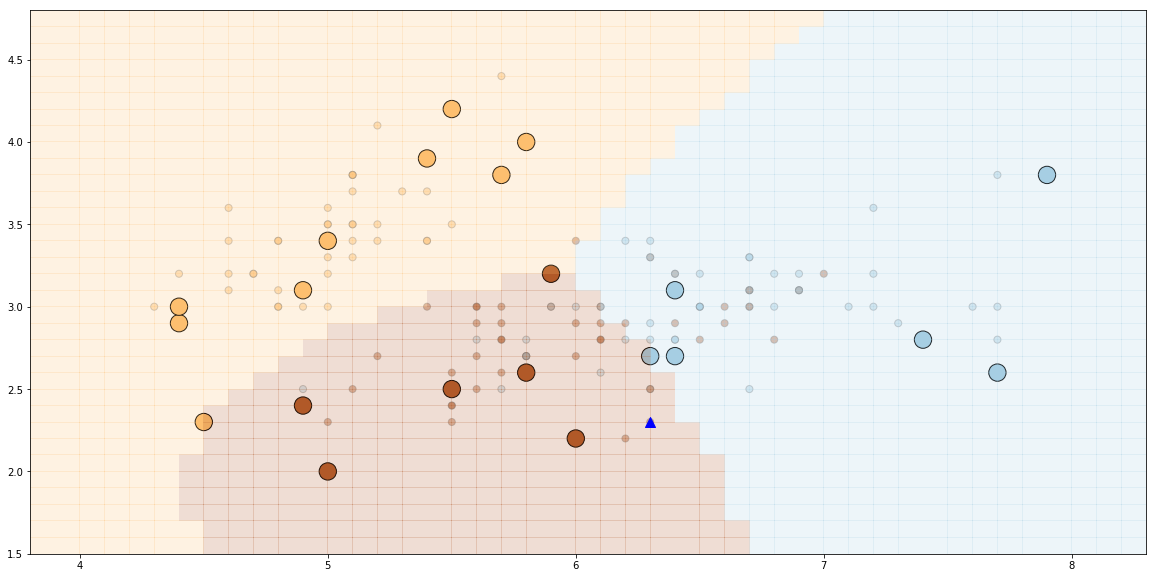

In [754]:
somthing()

The Gify from the above plots.

<img src="https://i.imgur.com/G65d07k.gif">

# Q1 b)iii

In [755]:
data = pd.read_csv("../../data/iris/iris.csv",
                   header=None,
                   names=['sepal length',
                          'sepal width',
                          'petal length',
                          'petal width',
                          'species'])
X = data.iloc[:, :2]
y = data.iloc[:, -1]
df = pd.DataFrame(X)
df.columns = ['x','y']

In [756]:
ylabels = (y == 'Iris-virginica') * 1
ylabels += (y == 'Iris-setosa') * 2
ylabels += (y == 'Iris-versicolor') * 3

In [757]:
df['class'] = ylabels

In [758]:
df.head(4)

,x,y,class
0,5.1,3.5,2
1,4.9,3.0,2
2,4.7,3.2,2
3,4.6,3.1,2


In [759]:
from sklearn.utils import shuffle
df = shuffle(df)
tupl = train_test_split(df, test_size = .3, shuffle=True)
df_train, df_test = tupl

In [760]:
# taking out unannotated
tupl = train_test_split(df_train, test_size=0.9)
df_annotated, df_unannotated = tupl

In [761]:
X_annotated = df_annotated[['x', 'y']].values
X_unannotated = df_unannotated[['x', 'y']].values
y_annotated = df_annotated['class'].values
y_unannotated = df_unannotated['class'].values

In [762]:
nb = NaiveBayes()
annotation_size = 1 # annotation batch size
active_learning_its = 10

accs_non_random = somthing(active_learning_its, plot=False, random_sampling=False)
accs_random = somthing(active_learning_its, plot=False, random_sampling=True)

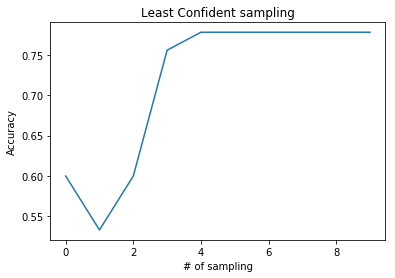

In [763]:
plt.plot(accs_non_random)
plt.title("Least Confident sampling")
plt.xlabel("# of sampling")
plt.ylabel("Accuracy");

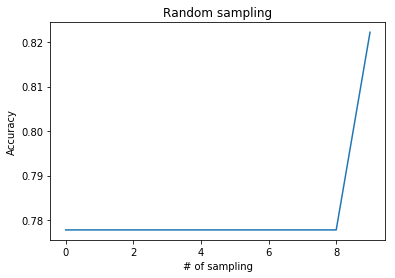

In [764]:
plt.plot(accs_random)
plt.title("Random sampling")
plt.xlabel("# of sampling")
plt.ylabel("Accuracy");

The graph shows the tradeoff that we might have to face.

- In the case of Least Confident, the graph shows that it is able to pick up the accuracy early-on without too much increase in the annotation costs. But as we see that the Least Confident Sampling is not able to achieve the accuracy that the random sampling method is able to achieve. This can be explained due to bias-ness of the model to try to learn the even points that may correspond to noise in the data. 

- Random on the other hand may pick up uniformly thus the concepts that can be learned from annotating randomly sampled data may correspond the majority of the data distribution.

If the only metric that we would like to target in a noisy data then it would be much better to randomly sample the data as the each data point would have equal probability of getting annotated therefore due the mere large number of the data points corresponding to the non-noisy data, we would not hurt our model by explictly teaching it to recognize noisy datapoints.